In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product
from scipy.stats import linregress


def load_input(filename="perc-ini.txt"):
    with open(filename, 'r') as f:
        data = [line.strip().split("%")[0] for line in f.readlines()]
    L, T, p0, pk, dp = map(float, data)
    return int(L), int(T), p0, pk, dp


def generate_lattice(L, p):
    # Generate an LxL lattice where each site is occupied with probability p
    return (np.random.random((L, L)) < p).astype(int)


def burning_method(lattice):
    L = len(lattice)
    burned = np.zeros_like(lattice, dtype=int)

    # Initialize the burning process
    front = [(0, i) for i in range(L) if lattice[0, i] == 1]
    for r, c in front:
        burned[r, c] = 1

    while front:
        new_front = []
        for r, c in front:
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < L and 0 <= nc < L and lattice[nr, nc] == 1 and burned[nr, nc] == 0:
                    burned[nr, nc] = 1
                    new_front.append((nr, nc))
        front = new_front

    # Check if the last row is reached
    percolates = np.any(burned[-1, :] == 1)
    return percolates


def hoshen_kopelman(lattice):
    L = len(lattice)
    labels = np.zeros_like(lattice, dtype=int)
    label = 0
    label_dict = {}

    for r, c in product(range(L), range(L)):
        if lattice[r, c] == 0:
            continue

        neighbors = []
        if r > 0 and labels[r - 1, c] > 0:
            neighbors.append(labels[r - 1, c])
        if c > 0 and labels[r, c - 1] > 0:
            neighbors.append(labels[r, c - 1])

        if not neighbors:
            label += 1
            labels[r, c] = label
            label_dict[label] = label
        else:
            min_label = min(neighbors)
            labels[r, c] = min_label
            for n in neighbors:
                label_dict[n] = min(label_dict[n], min_label)

    # Second pass to relabel clusters
    for r, c in product(range(L), range(L)):
        if labels[r, c] > 0:
            labels[r, c] = label_dict[labels[r, c]]

    # Count cluster sizes
    cluster_sizes = Counter(labels.flatten())
    cluster_sizes.pop(0, None)  # Remove the background cluster

    return cluster_sizes


def monte_carlo_simulation(L, T, p0, pk, dp):
    results = []
    p_values = np.arange(p0, pk + dp, dp)

    for p in p_values:
        flow_count = 0
        max_sizes = []

        cluster_distributions = Counter()

        for _ in range(T):
            lattice = generate_lattice(L, p)

            # Check percolation
            percolates = burning_method(lattice)
            flow_count += percolates

            # Find clusters
            cluster_sizes = hoshen_kopelman(lattice)
            max_sizes.append(max(cluster_sizes.values(), default=0))

            # Update cluster distribution
            cluster_distributions.update(cluster_sizes)

        Pf_low = flow_count / T
        avg_smax = np.mean(max_sizes)
        results.append((p, Pf_low, avg_smax))

        # Prepare and save cluster distribution for this p
        dist_filename = f"Dist-p{p:.2f}L{L}T{T}.txt"
        with open(dist_filename, 'w') as f:
            for s, n_s in sorted(cluster_distributions.items()):
                # Only write the data where the count is > 0 (necessary for log-log)
                if n_s > 0:
                    f.write(f"{s}  {n_s}\n")

    # Save results for p, Pf_low, ⟨smax⟩
    results_filename = f"Ave-L{L}T{T}.txt"
    with open(results_filename, 'w') as f:
        for p, Pf_low, avg_smax in results:
            f.write(f"{p:.2f}  {Pf_low}  {avg_smax}\n")
            



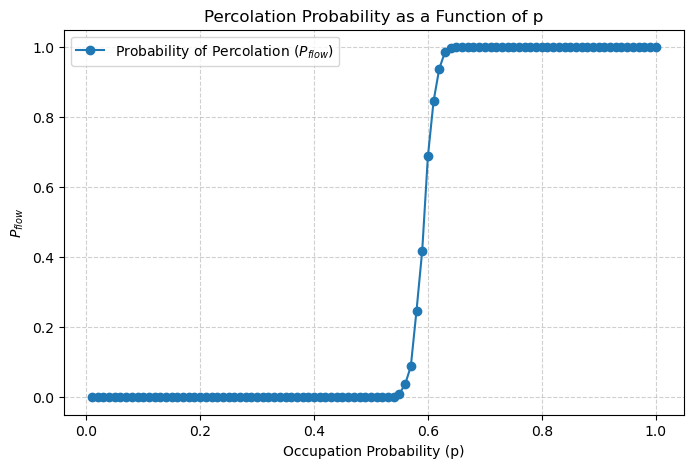

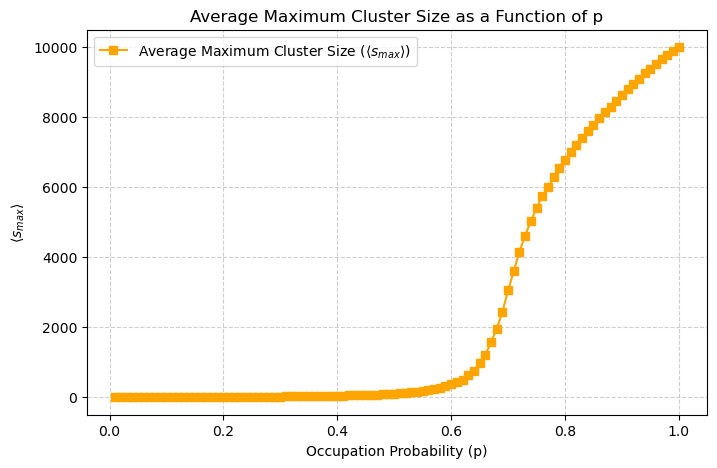

Could not load Dist-p1.00L100T1000.txt: too many indices for array: array is 1-dimensional, but 2 were indexed


/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_93701/281961954.py:60: UserWarning: loadtxt: input contained no data: "Dist-p1.00L100T1000.txt"
  dist_data = np.loadtxt(dist_filename)


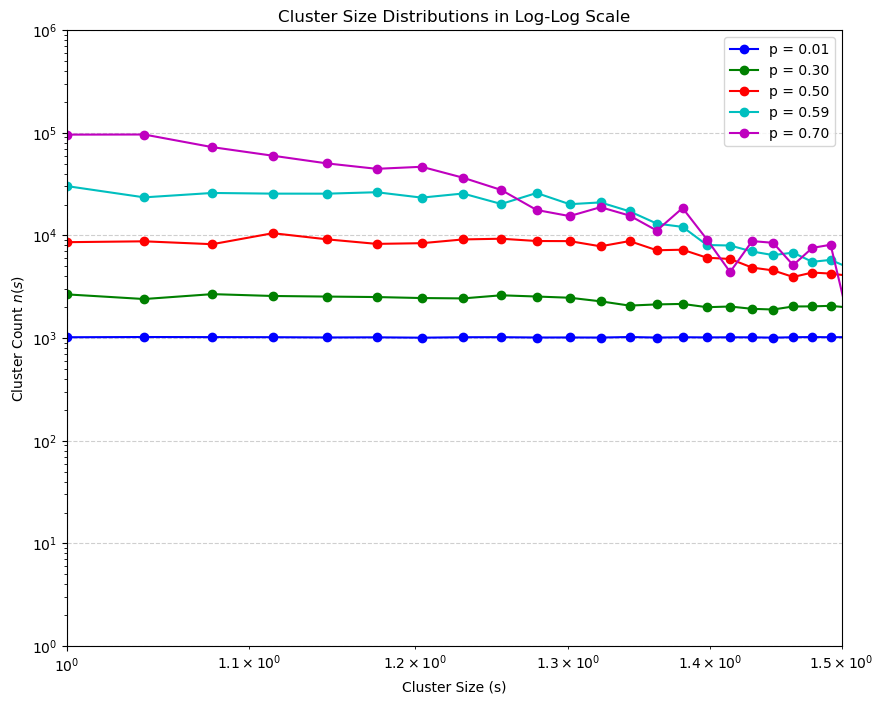

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_results(L, T, p0, pk, dp):
    # Load percolation and cluster size data
    results_filename = f"Ave-L{L}T{T}.txt"
    data = np.loadtxt(results_filename)

    p_values = data[:, 0]
    Pf_low = data[:, 1]
    avg_smax = data[:, 2]

    # Plot 1: Probability of Percolation
    plot_percolation_probability(p_values, Pf_low, L, T)

    # Plot 2: Average Size of the Maximum Cluster
    plot_avg_max_cluster_size(p_values, avg_smax, L, T)

    # Plot 3: Cluster Size Distributions for Specific p
    plot_cluster_size_distributions(L, T, p0, pk)


def plot_percolation_probability(p_values, Pf_low, L, T):
    plt.figure(figsize=(8, 5))
    plt.plot(p_values, Pf_low, 'o-',
             label="Probability of Percolation ($P_{flow}$)")
    plt.xlabel("Occupation Probability (p)")
    plt.ylabel("$P_{flow}$")
    plt.title("Percolation Probability as a Function of p")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig(f"PercolationProbability-L{L}T{T}.png")
    plt.show()


def plot_avg_max_cluster_size(p_values, avg_smax, L, T):
    plt.figure(figsize=(8, 5))
    plt.plot(p_values, avg_smax, 's-', color='orange',
             label="Average Maximum Cluster Size ($⟨s_{max}⟩$)")
    plt.xlabel("Occupation Probability (p)")
    plt.ylabel("$⟨s_{max}⟩$")
    plt.title("Average Maximum Cluster Size as a Function of p")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig(f"AvgMaxCluster-L{L}T{T}.png")
    plt.show()


def plot_cluster_size_distributions(L, T, p0, pk):
    cluster_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # Example p values (adjust as needed)
    p_samples = [p0, 0.3, 0.5, 0.592746, 0.7, pk]

    plt.figure(figsize=(10, 8))

    for idx, p in enumerate(p_samples):
        dist_filename = f"Dist-p{p:.2f}L{L}T{T}.txt"
        try:
            dist_data = np.loadtxt(dist_filename)
            s_values = dist_data[:, 0]
            n_values = dist_data[:, 1]

            # Plotting in log-log scale
            plt.plot(s_values, n_values, 'o-',
                     label=f"p = {p:.2f}", color=cluster_colors[idx % len(cluster_colors)])
        except Exception as e:
            print(f"Could not load {dist_filename}: {e}")

    # Set log-log scale for both axes
    plt.xscale('log')
    plt.yscale('log')

    # Adjust axis limits
    # Set minimum x value to 1 (log scale does not allow zero)
    plt.xlim([1, 1.5])
    plt.ylim([1, 1e6])   # Correct syntax for 10^6

    # Labels and title
    plt.xlabel("Cluster Size (s)")
    plt.ylabel("Cluster Count $n(s)$")
    plt.title("Cluster Size Distributions in Log-Log Scale")

    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Save and show plot
    plt.savefig(f"ClusterDistribution-L{L}T{T}.png")
    plt.show()


# Example usage
visualize_results(L=100, T=1000, p0=0.01, pk=1.0, dp=0.01)

/var/folders/1r/p1_3kg652bbgwr9qm_hgg_pc0000gn/T/ipykernel_93701/3279179888.py:11: UserWarning: loadtxt: input contained no data: "Dist-p1.00L100T1000.txt"
  dist_data = np.loadtxt(dist_filename)


Could not load Dist-p1.00L100T1000.txt: too many indices for array: array is 1-dimensional, but 2 were indexed


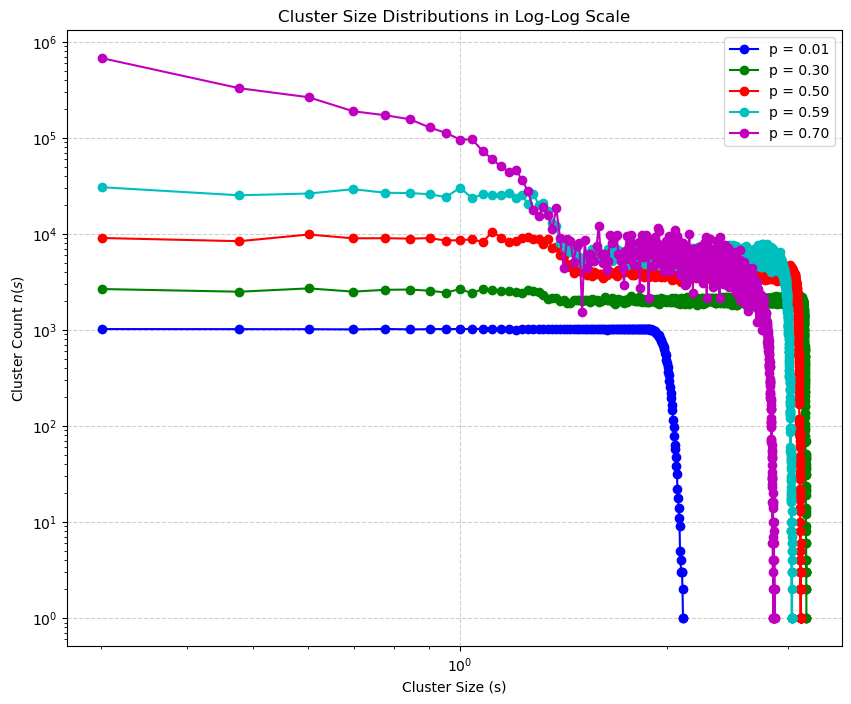

In [18]:
def plot_cluster_size_distributions(L, T, p0, pk, filter_data=None):
    cluster_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # Example p values (adjust as needed)
    p_samples = [p0, 0.3, 0.5, 0.592746, 0.7, pk]

    plt.figure(figsize=(10, 8))

    for idx, p in enumerate(p_samples):
        dist_filename = f"Dist-p{p:.2f}L{L}T{T}.txt"
        try:
            dist_data = np.loadtxt(dist_filename)
            s_values = dist_data[:, 0]
            n_values = dist_data[:, 1]

            # Apply filter_data if provided
            if filter_data:
                mask = filter_data(s_values, n_values)
                s_values = s_values[mask]
                n_values = n_values[mask]

            # Plotting in log-log scale
            plt.plot(s_values, n_values, 'o-',
                     label=f"p = {p:.2f}", color=cluster_colors[idx % len(cluster_colors)])
        except Exception as e:
            print(f"Could not load {dist_filename}: {e}")

    # Set log-log scale for both axes
    plt.xscale('log')
    plt.yscale('log')

    # Labels and title
    plt.xlabel("Cluster Size (s)")
    plt.ylabel("Cluster Count $n(s)$")
    plt.title("Cluster Size Distributions in Log-Log Scale")

    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Save and show plot
    plt.savefig(f"ClusterDistribution-L{L}T{T}.png")
    plt.show()
    

# Function to filter clusters with size < 100
def filter_clusters(s_values, n_values):
    return s_values < 100


# Call visualize_results with the custom filter
plot_cluster_size_distributions(
    L=100, T=1000, p0=0.01, pk=1.0, filter_data=filter_clusters)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the distribution data for p = 0.59
dist_data = np.loadtxt("Dist-p0.59L100T1000.txt")

# Extract cluster sizes and counts
s_values = dist_data[:, 0]
n_values = dist_data[:, 1]

# Remove sizes with very small counts (to reduce noise)
valid_indices = n_values > 1
s_values = s_values[valid_indices]
n_values = n_values[valid_indices]

# Further remove very small clusters that contribute to noise
threshold_size = 10  # Cluster size threshold
valid_indices = s_values >= threshold_size
s_values = s_values[valid_indices]
n_values = n_values[valid_indices]

# Plot in log-log scale
plt.figure(figsize=(8, 6))
plt.plot(s_values, n_values, 'o', label="Cluster Size Distribution")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Cluster Size (s)")
plt.ylabel("Cluster Count $n(s)$")
plt.title("Cluster Size Distribution for p = 0.59")
plt.grid(True, linestyle='--', alpha=0.6)

# Add a fitted power law line (if applicable)
log_s = np.log(s_values)
log_n = np.log(n_values)

# Fit a line to the log-log data
slope, intercept, _, _, _ = linregress(log_s, log_n)
plt.plot(s_values, np.exp(intercept) * s_values**slope,
         label=f"Power Law Fit (slope = {slope:.2f})", color='red', linestyle='--')

plt.legend()
plt.show()

ValueError: Inputs must not be empty.

Error in callback <function _draw_all_if_interactive at 0x10b6e39c0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 800x600 with 1 Axes>